<a href="https://colab.research.google.com/github/fabrihayra/BST-Housing-Analysis/blob/main/BST_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

2.12.0


For the Boston housing dataset, we get 506 rows of data, with 13 features in each. Our task is to build a regression model that takes these 13 features as input and output a single value prediction of the "median value of owner-occupied homes (in $1000).

In [8]:
(train_features, train_labels), (test_features, test_labels) = keras.datasets.boston_housing.load_data()

# get per-feature statistics (mean, standard deviation) from the training set to normalize by
train_mean = np.mean(train_features, axis=0)
train_std = np.std(train_features, axis=0)
train_features = (train_features - train_mean) / train_std

57026/57026 [==============================] - 0s 0us/step


##Building the model:

To build a neural network, we first need to configure its layers and then compile the model. In Keras, we can stack layers using the Sequential class. Once the layers are defined, we need to specify the loss function, optimizer, and metrics to monitor the model's performance during training.

For the network we want to build, we will use one hidden layer consisting of 20 neurons. To train the model for a regression problem, we will use mean squared error (MSE) as the loss function, which measures the difference between the predicted and actual values. The optimizer will be responsible for updating the model parameters based on the computed loss. Finally, we will select some metrics to monitor the training and testing steps.

In [16]:
def build_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(train_features[0])]),
        Dense(1)
    ])

    model.compile(optimizer=tf.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

##Training the model:

1. Feed the training data to the model—in this example, the '*train_features*' and '*train_labels arrays*'.
2. The model learns to associate features and labels.
3. Ask the model to make predictions about a test set—in this example, the *'test_features'* array. Verify that the predictions match the labels from the *'test_labels'* array.

In [19]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(train_features, train_labels, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# RMSE measure to compare to Kaggle leaderboard on https://www.kaggle.com/c/boston-housing/leaderboard
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................................
Final Root Mean Square Error on validation set: 2.455


##Conclusions:

The model training completed successfully and the final validation RMSE is 2.455. This means that on average, the model's predictions are off by about 2.455 units from the actual values.

Now, we'll plot the loss function measure on the training and validation sets:

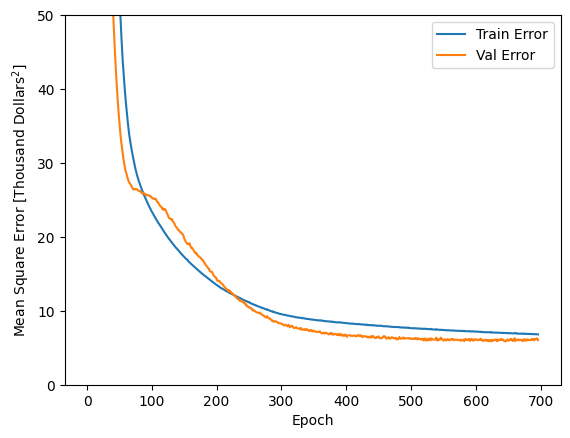

In [24]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Thousand Dollars$^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,50])

plot_history()

##Conclusion:

The training and validation metrics both improve and converge to similar values over epochs, this indicates that the model is learning the patterns in the data and is not overfitting or underfitting.

Now, comparing how the model performs on the test dataset:

In [25]:
test_features_norm = (test_features - train_mean) / train_std
mse, _, _ = model.evaluate(test_features_norm, test_labels)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

4/4 [==============================] - 0s 5ms/step - loss: 17.2064 - mae: 2.6245 - mse: 17.2064
Root Mean Square Error on test set: 4.148


##Trying other approaches to improve the model's test set performance:

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Loading the Boston Housing dataset
boston_housing = keras.datasets.boston_housing
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Spliting the training set into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Normalizing the training, validation, and test features
scaler = StandardScaler()
train_features_norm = scaler.fit_transform(train_features)
val_features_norm = scaler.transform(val_features)
test_features_norm = scaler.transform(test_data)

# Defining the function to build the model
def build_model(num_layers=1, num_neurons=20, learning_rate=0.001, dropout_rate=0.0):
    model = keras.Sequential()
    for _ in range(num_layers):
        model.add(Dense(num_neurons, activation='relu'))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])
    return model

# Building the model with the best hyperparameters from a grid search
model = build_model(num_layers=2, num_neurons=30, learning_rate=0.01, dropout_rate=0.2)

# Adding early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Training the model on the full training set with early stopping
history = model.fit(train_features_norm, train_labels, epochs=1000, verbose=0,
                    validation_data=(val_features_norm, val_labels), callbacks=[early_stop])

# Evaluating the model on the test set
mse, _, mae = model.evaluate(test_features_norm, test_labels, verbose=0)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))
print('Mean Absolute Error on test set: {}'.format(round(mae, 3)))


Root Mean Square Error on test set: 4.489
Mean Absolute Error on test set: 2.964


In [35]:
test_features_norm = (test_features - train_mean) / train_std
mse, _, _ = model.evaluate(test_features_norm, test_labels)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

4/4 [==============================] - 0s 10ms/step - loss: 8933158.0000 - mse: 8933158.0000 - mae: 2922.6072
Root Mean Square Error on test set: 2988.839


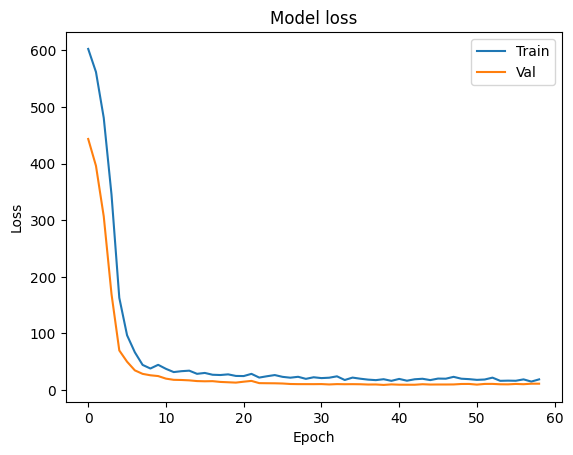

In [37]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()
